In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99),dtype=tf.float32)

In [3]:
! mkdir /kaggle/working/saves

mkdir: cannot create directory ‘/kaggle/working/saves’: File exists


In [4]:
import os
ptModelName = 'cnn'
dataSet = 'd1'
modelVersion = '1'
imageSize = '256'
modelName = f'{ptModelName}_{dataSet}_{imageSize}_{modelVersion}'

if not os.path.exists('/kaggle/working/saves/{}'.format(ptModelName)):
    os.mkdir('/kaggle/working/saves/{}'.format(ptModelName))
else:
    print('exists')

exists


In [5]:
train = gen.flow_from_directory("/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/",
                               target_size = (256,256),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")

Found 3681 images belonging to 2 classes.


In [6]:
val = gen.flow_from_directory("/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/",
                               target_size = (256,256),
                               batch_size = 8,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "validation")
classes = val.class_indices

Found 919 images belonging to 2 classes.


With grayscale as color mode we get high spikes in validation loss in training and substantially lower accuracy compared with a dataset with rgb color mode.

In [7]:
classes

{'Brain Tumor': 0, 'Healthy': 1}

In [8]:
import seaborn as sns

 Class distribution in training dataset

<AxesSubplot:>

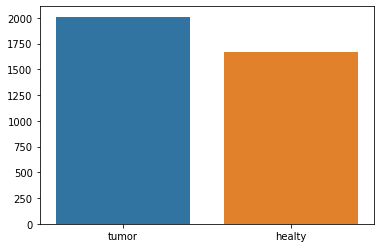

In [9]:
t=0
h=0
for i in range(15):
    a, b = next(train)
    for j in b:
        if j == 1:
            h+=1
        else:t+=1

sns.barplot(x=['tumor','healty'],y=[t,h])
    

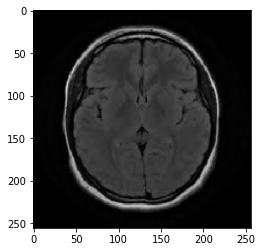

In [10]:
import matplotlib.pyplot as plt
batch = next(train)

plt.imshow(batch[0][0])

 Simple cnn

In [11]:
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

In [12]:
model = keras.Sequential()
model.add(InputLayer(input_shape=(256,256,3)))
model.add(Conv2D(filters=32,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(0.001),loss = BinaryCrossentropy(),metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               33554560  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

# Model plot

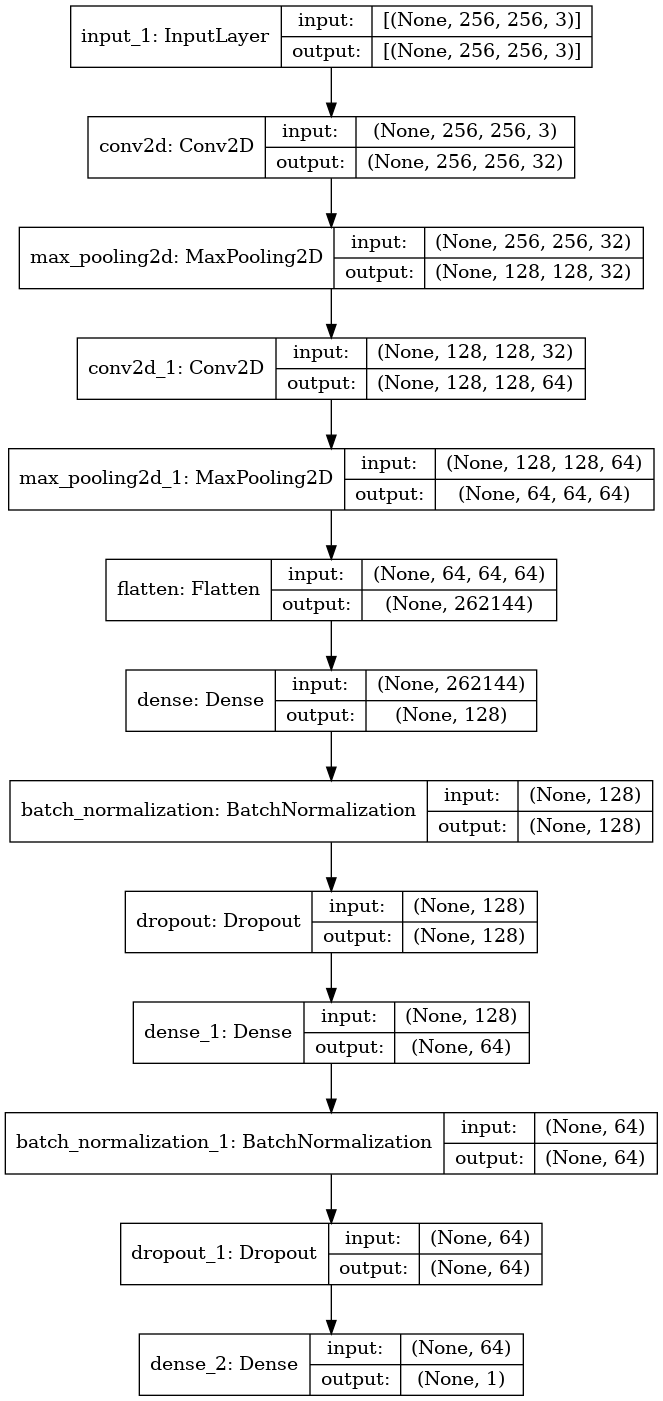

In [14]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

In [15]:
from keras.callbacks import ModelCheckpoint
weight_path="/kaggle/working/saves/{}/{}_weights.best.hdf5".format(ptModelName,modelName)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

In [16]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [17]:
history = model.fit(train,verbose=1,callbacks = [earlystopping, checkpoint],epochs=20,validation_data=(val))

Epoch 1/20
15/15 [==============================] - 80s 5s/step - loss: 0.6856 - accuracy: 0.6482 - val_loss: 1.0991 - val_accuracy: 0.7595

Epoch 00001: val_loss improved from inf to 1.09913, saving model to /kaggle/working/saves/cnn/cnn_d1_256_1_weights.best.hdf5
Epoch 2/20
15/15 [==============================] - 72s 5s/step - loss: 0.4034 - accuracy: 0.8235 - val_loss: 0.4280 - val_accuracy: 0.8335

Epoch 00002: val_loss improved from 1.09913 to 0.42802, saving model to /kaggle/working/saves/cnn/cnn_d1_256_1_weights.best.hdf5
Epoch 3/20
15/15 [==============================] - 72s 5s/step - loss: 0.2157 - accuracy: 0.9239 - val_loss: 0.2239 - val_accuracy: 0.9140

Epoch 00003: val_loss improved from 0.42802 to 0.22390, saving model to /kaggle/working/saves/cnn/cnn_d1_256_1_weights.best.hdf5
Epoch 4/20
15/15 [==============================] - 73s 5s/step - loss: 0.1089 - accuracy: 0.9702 - val_loss: 0.1956 - val_accuracy: 0.9336

Epoch 00004: val_loss improved from 0.22390 to 0.1955

 Plotting accuracy

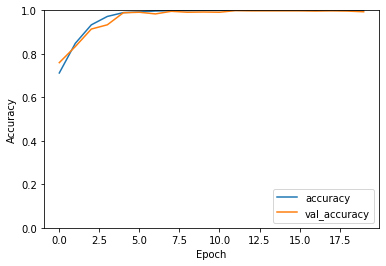

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

 Plotting loss

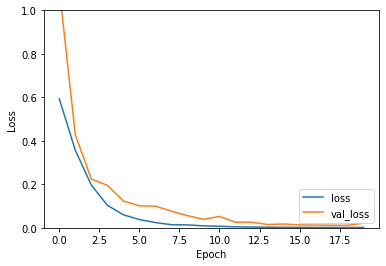

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

 Next step: Actually create a test set!
 This model will be sufficient for this task, so no need for a bigger model.

In [20]:
from IPython.display import FileLink, FileLinks

In [24]:
! ls /kaggle/working/saves/cnn/cnn_d1_256_1_weights.best.hdf5

cnn_d1_256_1_weights.best.hdf5


In [22]:
tf.__version__

'2.4.1'

In [36]:
FileLink(r'/kaggle/working/model.h5')

/kaggle/working/model.h5

In [28]:
model.save('/kaggle/working/model.h5')

In [35]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
if result[0][0] == 1:
    prediction = 'healthy'
else:
    prediction = 'tumor'
print(prediction)

tumor


In [31]:
train.class_indices

{'Brain Tumor': 0, 'Healthy': 1}